In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
pprint = lambda st : print(st.expandtabs(32))

# MultinomialNB

In [3]:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset?select=spam.csv

raw_df = pd.read_csv("data/spam.csv", encoding='latin-1')
raw_df.dropna(how="any", inplace=True, axis=1)
raw_df.columns = ['label', 'message']
display(raw_df.head())
display(raw_df.groupby('label').describe().T)

ham_words = Counter(sentence for sentence in raw_df[raw_df.label=='ham'].message)
pprint(f'3 most common ham sentence \t {ham_words.most_common(3)}')
spam_words = Counter(sentence for sentence in raw_df[raw_df.label=='spam'].message)
pprint(f'3 most common spam sentence \t {spam_words.most_common(3)}')

ham_words = Counter(word for list in raw_df[raw_df.label=='ham'].message.apply(lambda x: x.split()) for word in list)
pprint(f'10 most common ham word \t {ham_words.most_common(10)}')
spam_words = Counter(word for list in raw_df[raw_df.label=='spam'].message.apply(lambda x: x.split()) for word in list)
pprint(f'10 most common spam word \t {spam_words.most_common(10)}')

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

3 most common ham sentence       [("Sorry, I'll call later", 30), ('I cant pick the phone right now. Pls send a message', 12), ('Ok...', 10)]
3 most common spam sentence      [('Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!', 4), ('HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be won. Just answer 4 easy questions. Play Now! Send HMV to 86688 More info:www.100percent-real.com', 3), ("Loan for any purpose å£500 - å£75,000. Homeowners + Tenants welcome. Have you been previously refused? We can still help. Call Free 0800 1956669 or text back 'help'", 3)]
10 most common ham word          [('to', 1530), ('you', 1458), ('I', 1436), ('the', 1019), ('a', 969), ('and', 738), ('i', 736), ('in', 734), ('u', 645), ('is', 638)]
10 most common spam word         [('to', 604), ('a', 358), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is',

# Feature Extraction

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think goes usf lives around though


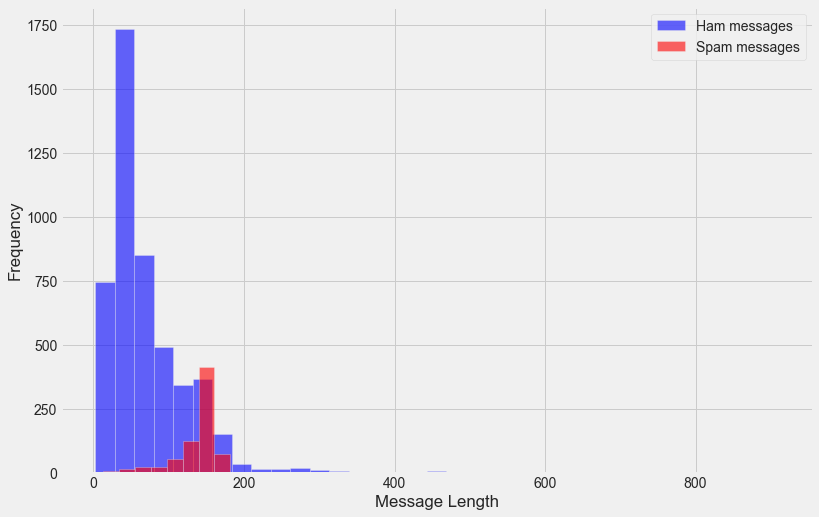

In [11]:
raw_df['label_num'] = raw_df.label.map({'ham':0, 'spam':1})
raw_df['message_len'] = raw_df.message.apply(len)
plt.figure(figsize=(12, 8))

raw_df[raw_df.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
raw_df[raw_df.label=='spam'].message_len.plot(kind='hist', color='red', label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")
raw_df.groupby('label_num').describe()

def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    nopunc_lower = ''.join([char.lower() for char in mess if char not in string.punctuation])
    return ' '.join([word for word in nopunc_lower.split() if word not in STOPWORDS])
raw_df['clean_msg'] = raw_df.message.apply(text_process)

raw_df.head()

In [12]:
X = raw_df.clean_msg
y = raw_df.label_num

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
pprint(f'X_train, X_test shape \t {X_train.shape} {X_test.shape}')
pprint(f'y_train, y_test shape \t {y_train.shape} {y_test.shape}')

X_train, X_test shape            (4179,) (1393,)
y_train, y_test shape            (4179,) (1393,)


In [13]:
for vect in (CountVectorizer(), TfidfVectorizer(), CountVectorizer(ngram_range = (1, 3))):
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    display(X_train_dtm)

    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)

    y_pred = nb.predict(X_test_dtm)
    pprint(f'accuracy \t {metrics.accuracy_score(y_test, y_pred)}')
    display(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index=['actual spam', 'actual ham'], columns=['predict spam', 'predict ham']))

<4179x7996 sparse matrix of type '<class 'numpy.int64'>'
	with 34796 stored elements in Compressed Sparse Row format>

accuracy                         0.9827709978463748


,predict spam,predict ham
actual spam,1205,8
actual ham,16,164


<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

accuracy                         0.9669777458722182


,predict spam,predict ham
actual spam,1213,0
actual ham,46,134


<4179x56873 sparse matrix of type '<class 'numpy.int64'>'
	with 94665 stored elements in Compressed Sparse Row format>

accuracy                         0.9856424982053122


,predict spam,predict ham
actual spam,1210,3
actual ham,17,163


# Multilayer Perceptron

In [30]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [17]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [22]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [23]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.fit(sequences_matrix, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [26]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

44/44 [==============================] - 1s 12ms/step - loss: 0.0630 - accuracy: 0.9849
Test set
  Loss: 0.063
  Accuracy: 0.985
